# First Shot v1.0
This is for subtask A: Validation.

Update by 2021.7.30

## 1. Load data and model

In [1]:
import argparse
from typing import Dict
import torch
import torch.utils.data.distributed
import pprint
import numpy as np
import pandas as pd
import os
import time
from transformers import RobertaTokenizer, RobertaConfig, DistilBertTokenizerFast
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW

default_args = {
    "max_seq_length": 128
}

def get_all_features_from_task_1(questions_path,
                                 answers_path,
                                 tokenizer,
                                 max_seq_length,
                                 with_gnn=False,
                                 with_k_bert=False):
    semantic_features = get_features_from_task_1(questions_path=questions_path,
                                                 answers_path=answers_path,
                                                 tokenizer=tokenizer,
                                                 max_seq_length=max_seq_length)

    return semantic_features


def get_features_from_task_1(questions_path, answers_path, tokenizer, max_seq_length):
    questions = pd.read_csv(questions_path)
    answers = pd.read_csv(answers_path, header=None, names=['id', 'ans'])

    # data = pd.merge(questions, answers, how='left', on='id')

    train_encodings = tokenizer(list(questions["sent0"]), list(questions["sent1"]), truncation=True, padding=True)

    return train_encodings, list(answers['ans'])


def create_datasets_with_kbert(features, shuffle=True):
    # if shuffle:
    #     perm = torch.randperm(len(features))
    #     features = [features[i] for i in perm]

    x = features[0]
    y = features[1]
#     return MyDataset(x, y)
    return IMDbDataset(x, y)


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, item):
        return self.x[item], self.y[item]

    def __len__(self):
        lenx = len(self.x)
        leny = len(self.y)
        assert lenx == leny
        return lenx

    
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)



In [2]:

# prepare for tokenizer and model
# tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
config = RobertaConfig.from_pretrained('roberta-large')

# config.hidden_dropout_prob = 0.2
# config.attention_probs_dropout_prob = 0.2

# train_data = test_data = optimizer = None
# train_features, dev_features, test_features = [], [], []

train_features = get_all_features_from_task_1(
    'ALL data/Training Data/subtaskA_data_all.csv',
    'ALL data/Training Data/subtaskA_answers_all.csv',
    tokenizer, default_args['max_seq_length'])
dev_features = get_all_features_from_task_1(
    'ALL data/Dev Data/subtaskA_dev_data.csv',
    'ALL data/Dev Data/subtaskA_gold_answers.csv',
    tokenizer, default_args['max_seq_length'])
test_features = get_all_features_from_task_1(
    'ALL data/Test Data/subtaskA_test_data.csv',
    'ALL data/Test Data/subtaskA_gold_answers.csv',
    tokenizer, default_args['max_seq_length'])


In [3]:
train_dataset = create_datasets_with_kbert(train_features, shuffle=True)
dev_dataset = create_datasets_with_kbert(dev_features, shuffle=False)
test_dataset = create_datasets_with_kbert(test_features, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [4]:

device = torch.device('cuda:2') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)
model.train()


optim = AdamW(model.parameters(), lr=5e-5)



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

In [5]:
# Predict function
def predict(outputs):
    pred = outputs["logits"].softmax(dim=1).argmax(dim=1, keepdim=True)
    return pred

## 2. Training

In [6]:
# Train

from tqdm import tqdm

print('Start training...')
train_data = list(train_loader)

model.train()

train_loss = list()

epochs = 10
for epoch in range(epochs):
    print('Epoch %s/%s' % (epoch + 1, epochs))
    time.sleep(0.2)
    
    correct = 0
    count = 0
#     train_loss = 0.0
    pred_list = []
    
    epoch_loss = list()
    
    pbar = tqdm(train_data)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        
        # predict
        pred = predict(outputs)
        pred_list.append(outputs[1].softmax(dim=1))
        # print(output[1].softmax(dim=1))
        # count acc
        correct += pred.eq(labels.view_as(pred)).sum().item()
        count += len(labels)
#         train_loss += loss.item()
        
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'acc': '{:.3f}'.format(correct * 1.0 / count)
        })
        
        epoch_loss.append(loss.item())
        
    pbar.close()
    train_loss += epoch_loss

# model.eval()

Start training...
Epoch 1/10


100%|██████████| 625/625 [00:24<00:00, 25.21it/s, loss=0.464, acc=0.562]


Epoch 2/10


100%|██████████| 625/625 [00:25<00:00, 24.64it/s, loss=0.300, acc=0.773]


Epoch 3/10


100%|██████████| 625/625 [00:26<00:00, 23.75it/s, loss=0.172, acc=0.881]


Epoch 4/10


100%|██████████| 625/625 [00:25<00:00, 24.93it/s, loss=0.020, acc=0.937]


Epoch 5/10


100%|██████████| 625/625 [00:26<00:00, 23.88it/s, loss=0.060, acc=0.966]


Epoch 6/10


100%|██████████| 625/625 [00:25<00:00, 24.39it/s, loss=0.369, acc=0.975]


Epoch 7/10


100%|██████████| 625/625 [00:25<00:00, 24.45it/s, loss=0.038, acc=0.982]


Epoch 8/10


100%|██████████| 625/625 [00:25<00:00, 24.40it/s, loss=0.011, acc=0.984]


Epoch 9/10


100%|██████████| 625/625 [00:27<00:00, 22.82it/s, loss=0.001, acc=0.986]


Epoch 10/10


100%|██████████| 625/625 [00:25<00:00, 24.24it/s, loss=0.033, acc=0.986]


In [7]:
# torch.cat(pred_list, dim=0)

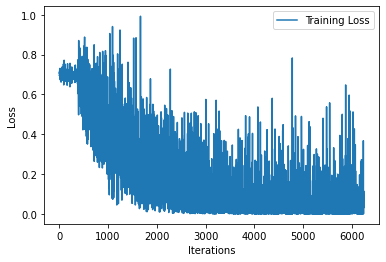

In [8]:
# Visualise loss

import matplotlib.pyplot as plt
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [9]:
# Train (First try)

# for epoch in range(3):
#     for batch in train_loader:
#         optim.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs[0]
#         loss.backward()
#         optim.step()

# model.eval()

## 3. Validation and test

In [10]:
# Test

from tqdm import tqdm

print('Start test...')
time.sleep(0.2)
test_data = list(test_loader)

model.eval()

with torch.no_grad():
    correct = 0
    count = 0
    
    pbar = tqdm(test_data)
    record = list()
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        
        # predict
        pred = predict(outputs)
        pred_list.append(outputs[1].softmax(dim=1))
        # print(output[1].softmax(dim=1))
        # count acc
        correct += pred.eq(labels.view_as(pred)).sum().item()
        count += len(labels)
#         train_loss += loss.item()

        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'acc': '{:.3f}'.format(correct * 1.0 / count)
        })
    

        record.append((int(pred),int(labels)))
        
#         break

    pbar.close()



Start test...


100%|██████████| 1000/1000 [00:07<00:00, 125.40it/s, loss=0.001, acc=0.801]


In [11]:
for idx,item in enumerate(record):
    print("Statement %s:" % idx)
    print("Model Prediction:",item[0],"vs. Ground Truth:",item[1])


Statement 0:
Model Prediction: 0 vs. Ground Truth: 0
Statement 1:
Model Prediction: 0 vs. Ground Truth: 0
Statement 2:
Model Prediction: 0 vs. Ground Truth: 0
Statement 3:
Model Prediction: 0 vs. Ground Truth: 0
Statement 4:
Model Prediction: 1 vs. Ground Truth: 1
Statement 5:
Model Prediction: 1 vs. Ground Truth: 0
Statement 6:
Model Prediction: 1 vs. Ground Truth: 1
Statement 7:
Model Prediction: 1 vs. Ground Truth: 0
Statement 8:
Model Prediction: 1 vs. Ground Truth: 0
Statement 9:
Model Prediction: 0 vs. Ground Truth: 1
Statement 10:
Model Prediction: 0 vs. Ground Truth: 0
Statement 11:
Model Prediction: 1 vs. Ground Truth: 0
Statement 12:
Model Prediction: 0 vs. Ground Truth: 0
Statement 13:
Model Prediction: 1 vs. Ground Truth: 1
Statement 14:
Model Prediction: 0 vs. Ground Truth: 1
Statement 15:
Model Prediction: 1 vs. Ground Truth: 1
Statement 16:
Model Prediction: 0 vs. Ground Truth: 0
Statement 17:
Model Prediction: 1 vs. Ground Truth: 0
Statement 18:
Model Prediction: 1 vs. 

Statement 507:
Model Prediction: 1 vs. Ground Truth: 1
Statement 508:
Model Prediction: 0 vs. Ground Truth: 1
Statement 509:
Model Prediction: 1 vs. Ground Truth: 0
Statement 510:
Model Prediction: 1 vs. Ground Truth: 1
Statement 511:
Model Prediction: 1 vs. Ground Truth: 1
Statement 512:
Model Prediction: 1 vs. Ground Truth: 1
Statement 513:
Model Prediction: 1 vs. Ground Truth: 1
Statement 514:
Model Prediction: 1 vs. Ground Truth: 0
Statement 515:
Model Prediction: 1 vs. Ground Truth: 1
Statement 516:
Model Prediction: 0 vs. Ground Truth: 0
Statement 517:
Model Prediction: 1 vs. Ground Truth: 1
Statement 518:
Model Prediction: 0 vs. Ground Truth: 0
Statement 519:
Model Prediction: 0 vs. Ground Truth: 1
Statement 520:
Model Prediction: 1 vs. Ground Truth: 1
Statement 521:
Model Prediction: 1 vs. Ground Truth: 1
Statement 522:
Model Prediction: 0 vs. Ground Truth: 0
Statement 523:
Model Prediction: 0 vs. Ground Truth: 0
Statement 524:
Model Prediction: 1 vs. Ground Truth: 1
Statement 

In [12]:
# Manual Test

check_id = 0

test_data = list(test_loader)
check_target = test_data[check_id]
# print("check_target:",check_target)

input_ids = check_target['input_ids'].to(device)
attention_mask = check_target['attention_mask'].to(device)
labels = check_target['labels']
# print("input_ids:",input_ids)


statements_str = tokenizer.decode(input_ids[0],skip_special_tokens=False)
# print("statements_str:",statements_str)
statements = statements_str.split("[CLS]")[1].split("[SEP]")
print("Task: Which statement of the two is against common sense?")
print("Statement 0:",statements[0])
print("Statement 1:",statements[1])
print()

outputs = model(input_ids, attention_mask=attention_mask)
prediction = predict(outputs)
print("Model Prediction:",int(prediction))
print("Ground Truth:",int(labels))

Task: Which statement of the two is against common sense?
Statement 0:  he loves to stroll at the park with his bed 
Statement 1:  he loves to stroll at the park with his dog. 

Model Prediction: 0
Ground Truth: 0
